In [1]:
import torch
from policy_networks.mlp import PolicyNet
from policy_networks.rnn import RNNPolicyNet
from torch import optim
from tasks import RandomMaze
import numpy as np
from tasks.Env import Env
from tasks import Maze_config
from gvf_networks.tabular import Tabular
from utils import train_epoch
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pickle
from mazelab.generators import random_maze
import gym
%matplotlib inline

In [2]:
# get gpu when available
if torch.cuda.is_available():
    use_gpu = True
    device = torch.device("cuda:0")
    print("GPU is available", flush=True)
else:
    use_gpu = False
    device = torch.device("cpu")
    print("no GPU found", flush=True)

no GPU found


In [3]:
# parameters
gammas = [0.98]
num_actions = 4
lr_adam = 5e-4
env_name = 'RandomMaze-v0'
size = 10
depth = 5
lr = {'sr': 0.3, 'gvfs': 0.6, 'Q': 0.1}
thresholds = {'sr': 0.6, 'gvfs': 0.1}
change = 50  # maze is changed every change epochs
batch_size = 1000
nb_epochs = 10000
nb_episodes_random_policy = 20
network = 'mlp' # or rnn
assert(network in ['mlp', 'rnn'])

# for plotting purposes
x_grid,y_grid = np.meshgrid(np.linspace(20,480,size),np.linspace(20,480,size))


# declare gvf network
gvf_net_xf = Tabular(size=size, num_actions=num_actions, depth=depth, gammas=gammas, 
                  thresholds=thresholds, lr=lr)
gvf_net_k1 = Tabular(size=size, num_actions=num_actions, depth=depth, gammas=gammas, 
                  thresholds=thresholds, lr=lr)
gvf_net_k2 = Tabular(size=size, num_actions=num_actions, depth=depth, gammas=gammas, 
                  thresholds=thresholds, lr=lr)

# declare policy network
logits_net = RNNPolicyNet(4 + (depth + 1) * num_actions * len(gammas), num_actions).to(device) if network == 'rnn' \
                    else PolicyNet(4 + (depth + 1) * num_actions * len(gammas), num_actions).to(device)

# make optimizer
optimizer = optim.Adam(logits_net.parameters(), lr=lr_adam)

# define environment
env, L = RandomMaze.main(env_name=env_name, size=size)

In [ ]:
total_reward = []

# training loop
for i in range(nb_epochs):
    clear_output(wait=True)
    
    # new network
    if i==0 or i%change==0:
        # reset gvf network
        gvf_net_xf.reset()
        gvf_net_k1.reset()
        gvf_net_k2.reset()
        # new environment
#         env, L = RandomMaze.main(start_position='goal_position',env_name=env_name, size=size)
        Maze_config.x = random_maze(width=size, height=size, complexity=1, density=0.5)
        Maze_config.xf_idx = [L[np.random.randint(0, len(L))]]
        Maze_config.k1_idx = [L[np.random.randint(0, len(L))]]
        Maze_config.k2_idx = [L[np.random.randint(0, len(L))]]
        Maze_config.start_idx = [L[np.random.randint(0, len(L))]]                
    elif np.any([(i-k)%change == 0 for k in range(0,2)]): # for first 3 episodes, start at goal
        # set start position to goal
        Maze_config.start_idx = Maze_config.k1_idx
    elif np.any([(i-k)%change == 0 for k in range(2,4)]): # for first 3 episodes, start at goal
        # set start position to goal
        Maze_config.start_idx = Maze_config.k2_idx
    elif np.any([(i-k)%change == 0 for k in range(4,6)]): # for first 3 episodes, start at goal
        # set start position to goal
        Maze_config.start_idx = Maze_config.xf_idx
    else:
        # random new position
        Maze_config.start_idx = [L[np.random.randint(0, len(L))]]

    #choose which subgoal is the target in this epoch:
    which_subgoal = np.random.randint(3)

    # training
    batch_loss, batch_rets, batch_lens = train_epoch(i, change, batch_size, env,  gvf_net_xf, gvf_net_k1, gvf_net_k2, logits_net, 
                                                     optimizer, device, nb_episodes_random_policy, which_subgoal)

    print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
            (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

    if np.all([(i - k) % change != 0 for k in range(nb_episodes_random_policy)]):
        total_reward.append(np.mean(batch_lens))
    
    if False:
        policy_all_states_k1 = logits_net.get_policy_all_states(env, gvf_net_k1,0, device)
        policy_all_states_k2 = logits_net.get_policy_all_states(env, gvf_net_k2,1, device)
        policy_all_states_xf = logits_net.get_policy_all_states(env, gvf_net_xf,2, device)

        # figure of policy network
        plt.figure()
        img = env.render('rgb_array')    
        plt.imshow(img)
        plt.quiver(x_grid, 
                   y_grid, 
                   policy_all_states_k1[:,:,3] - policy_all_states_k1[:,:,2],
                   policy_all_states_k1[:,:,0] - policy_all_states_k1[:,:,1])

        plt.figure()
        plt.imshow(img)
        plt.quiver(x_grid, 
                   y_grid, 
                   policy_all_states_k2[:,:,3] - policy_all_states_k2[:,:,2],
                   policy_all_states_k2[:,:,0] - policy_all_states_k2[:,:,1])

        plt.figure()
        plt.imshow(img)
        plt.quiver(x_grid, 
                   y_grid, 
                   policy_all_states_xf[:,:,3] - policy_all_states_xf[:,:,2],
                   policy_all_states_xf[:,:,0] - policy_all_states_xf[:,:,1])

        # figure of reward
        plt.figure()
        plt.plot(total_reward)
        plt.show()

In [ ]:
from scipy.signal import savgol_filter
plt.figure()
plt.plot(savgol_filter(total_reward,51,1))
plt.show()

In [ ]:
import pickle
#pickle.dump([i, change, batch_size, gvf_net_xf, gvf_net_k1, gvf_net_k2, logits_net, 
#            optimizer, device, nb_episodes_random_policy, which_subgoal], open('temp_small.pkl', 'wb'))

## ABSTRACTIONAL GVFS

In [4]:
import pickle
[_, _, _, _, _, _, logits_net, 
            _, _, _, _] = pickle.load(open('temp_small.pkl', 'rb'))

In [5]:
from gvf_networks.tabular import Tabular
structural_gvf = Tabular(size=size, num_actions=3, depth=3, nb_subgoals_in_state=2,
                         gammas=gammas, thresholds=thresholds, lr=lr)

def format_input(pos, r_pos, size, gvf_net) -> np.array:
    return np.array([(pos[0] - size / 2) / 25, (pos[1] - size / 2) / 25,
           (r_pos[0] - size / 2) / 25, (r_pos[1] - size / 2) / 25] + \
           gvf_net.gvfs[:, pos[0], pos[1], :, :].flatten().tolist() + \
           gvf_net.Q_gamma[pos[0], pos[1], :, :].flatten().tolist())

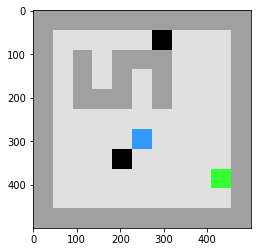

In [6]:
# reset navigational gvfs
gvf_net_xf.reset()
gvf_net_k1.reset()
gvf_net_k2.reset()

# reset structural gvfs
structural_gvf.reset()

# new environment
Maze_config.x = random_maze(width=size, height=size, complexity=1, density=0.1)
Maze_config.xf_idx = [L[np.random.randint(0, len(L))]]
Maze_config.k1_idx = [L[np.random.randint(0, len(L))]]
Maze_config.k2_idx = [L[np.random.randint(0, len(L))]]
Maze_config.start_idx = [L[np.random.randint(0, len(L))]]
env.reset()

# plot new environment
env.reset()
plt.figure()
img = env.render('rgb_array')    
plt.imshow(img)

In [7]:
# learn navigational gvfs
env.reset()
for i in range(nb_episodes_random_policy):       
    if np.any([(i-k)%change == 0 for k in range(0,2)]): # for first 3 episodes, start at goal 1
        Maze_config.start_idx = Maze_config.k1_idx
        which_subgoal = 0
    elif np.any([(i-k)%change == 0 for k in range(2,4)]): # for first 3 episodes, start at goal 2
        Maze_config.start_idx = Maze_config.k2_idx
        which_subgoal = 1
    elif np.any([(i-k)%change == 0 for k in range(4,6)]): # for first 3 episodes, start at end goal
        Maze_config.start_idx = Maze_config.xf_idx
        which_subgoal = 2
    else:
        Maze_config.start_idx = [L[np.random.randint(0, len(L))]]
        which_subgoal = np.random.randint(3)
    
    # learning navigational gvfs
    _, _, _ = train_epoch(i, change, batch_size, env,  gvf_net_xf, gvf_net_k1, gvf_net_k2, logits_net, 
                                                     optimizer, device, nb_episodes_random_policy, which_subgoal)

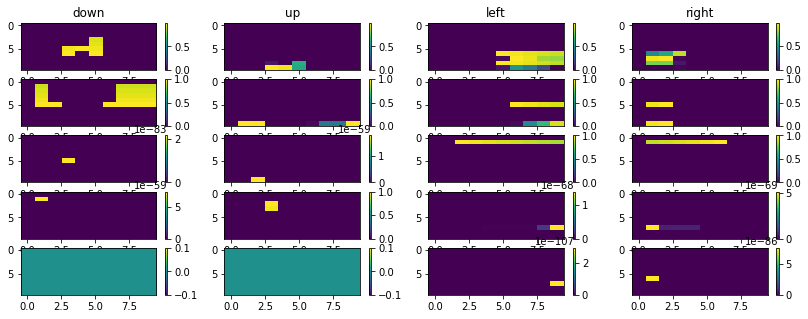

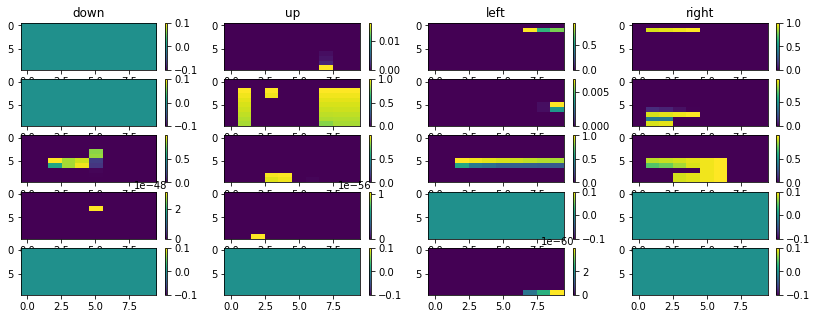

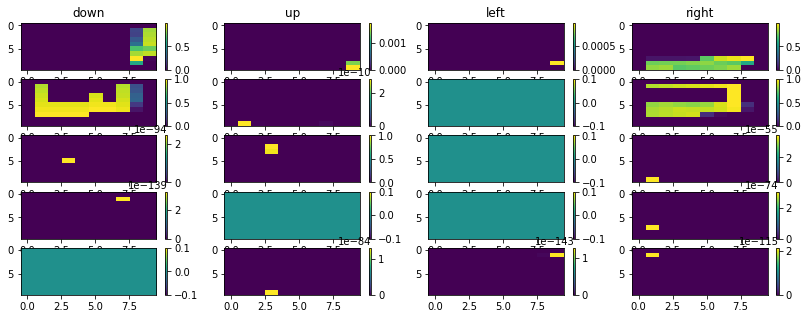

In [8]:
plt.figure(figsize=(14, 5))
for i_plot in range(20):
    plt.subplot(5, 4, i_plot + 1)
    plt.imshow(gvf_net_k1.gvfs[int(i_plot/4), :, :, -1, int(i_plot%4)], aspect='auto')
    if i_plot <= 3:
        plt.title(np.array(['down', 'up', 'left', 'right'])[i_plot])
    plt.colorbar()

plt.figure(figsize=(14, 5)) 
for i_plot in range(20):
    plt.subplot(5, 4, i_plot + 1)
    plt.imshow(gvf_net_k2.gvfs[int(i_plot/4), :, :, -1, int(i_plot%4)], aspect='auto')
    if i_plot <= 3:
        plt.title(np.array(['down', 'up', 'left', 'right'])[i_plot])
    plt.colorbar()

plt.figure(figsize=(14, 5))
for i_plot in range(20):
    plt.subplot(5, 4, i_plot + 1)
    plt.imshow(gvf_net_xf.gvfs[int(i_plot/4), :, :, -1, int(i_plot%4)], aspect='auto')
    if i_plot <= 3:
        plt.title(np.array(['down', 'up', 'left', 'right'])[i_plot])
    plt.colorbar()

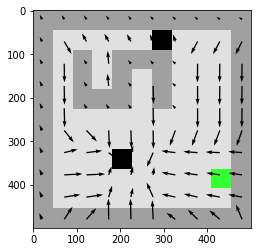

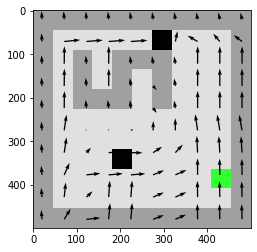

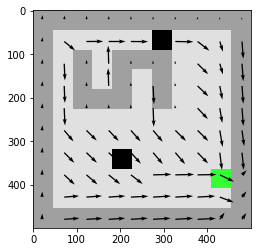

In [9]:
policy_all_states_k1 = logits_net.get_policy_all_states(env, gvf_net_k1,0, device)
policy_all_states_k2 = logits_net.get_policy_all_states(env, gvf_net_k2,1, device)
policy_all_states_xf = logits_net.get_policy_all_states(env, gvf_net_xf,2, device)

# figure of policy network
plt.figure()
img = env.render('rgb_array')    
plt.imshow(img)
plt.quiver(x_grid, 
           y_grid, 
           policy_all_states_k1[:,:,3] - policy_all_states_k1[:,:,2],
           policy_all_states_k1[:,:,0] - policy_all_states_k1[:,:,1])

plt.figure()
plt.imshow(img)
plt.quiver(x_grid, 
           y_grid, 
           policy_all_states_k2[:,:,3] - policy_all_states_k2[:,:,2],
           policy_all_states_k2[:,:,0] - policy_all_states_k2[:,:,1])

plt.figure()
plt.imshow(img)
plt.quiver(x_grid, 
           y_grid, 
           policy_all_states_xf[:,:,3] - policy_all_states_xf[:,:,2],
           policy_all_states_xf[:,:,0] - policy_all_states_xf[:,:,1])

In [38]:
nb_steps_structural_gvfs = 1000000
structural_gvf.reset()
#structural_gvf.lr['sr']        = 0.8
structural_gvf.thresholds['gvfs'] = 0.05

# navigational goals
k1_pos = np.squeeze(env.maze.objects.k1.positions).copy()
k2_pos = np.squeeze(env.maze.objects.k2.positions).copy()
xf_pos = np.squeeze(env.maze.objects.xf.positions).copy()
nav_goals = [k1_pos, k2_pos, xf_pos]

# navigational gvfs
nav_gvfs = [gvf_net_k1, gvf_net_k2, gvf_net_xf]

#choose a navigational policy for behavior
which_navigation_policy = np.random.randint(3)
nav_goal     = nav_goals[which_navigation_policy]
nav_gvf      = nav_gvfs[which_navigation_policy]
nav_policies_lst, counts, nb_utilities = [], [], []

# reset episode
_, done, sub_state, count, states_lst = env.reset(), False, np.zeros(3), 0, []

sr_max = []

for i_step in range(nb_steps_structural_gvfs):
    pos   = np.squeeze(env.maze.objects.agent.positions).copy()
    state = np.array(np.concatenate((np.array(sub_state)[:-1], pos)), dtype=np.int)

    # behavior policy
    obs = format_input(pos, nav_goal, size, nav_gvf)

    # get act and prob
    act, _ = logits_net.get_action(torch.as_tensor(obs, dtype=torch.float32).to(device))
    pi_behav = np.array(logits_net.get_policy(torch.as_tensor(obs, 
                                                              dtype=torch.float32).
                                              to(device), None)[0].probs.detach()[act])

    # get target
    pi_targets = np.array([
                           logits_net.get_policy(torch.as_tensor(format_input(pos, g, size, b), 
                                                                 dtype=torch.float32).to(device)
                                                 ,None)[0].probs.detach()[act] 
                           for (g, b) in zip(nav_goals, nav_gvfs)])

    assert(pi_targets[which_navigation_policy] == pi_behav)

    # move
    _, sub_state, done, _ = env.step(act)
    
#    if done and count!=199:
#        assert(False)
    states_lst.append(sub_state)
    
    # next position
    pos_next = np.squeeze(env.maze.objects.agent.positions).copy()
    
    #if structural_gvf.gvfs[0,sub_state[0]*1,sub_state[1]*1, pos_next[0], pos_next[1], 0, -2] > 0.4 and \
    #    structural_gvf.gvfs[0,sub_state[0]*1,sub_state[1]*1, pos_next[0], pos_next[1], 0, -2] < 0.42:
    #    assert(False)
    # utility
    utility = (sub_state[-1] == 1) * 1. #np.all(sub_state[:2]) * (sub_state[-1] == 1) * 1.
    nb_utilities.append(utility)
    
    # next state
    state_next = np.array(np.concatenate((np.array(sub_state)[:-1], pos_next)), dtype=np.int)

    #if np.all(sub_state[:2]) and done and count<199:
    #    assert(False)

    # update structural gvfs
    structural_gvf.update(state, utility, which_navigation_policy, state_next, L, 
                          pi_behav=pi_behav, pi_targets=pi_targets)
    
    if np.any(structural_gvf.gvfs[0, 1, 1] > 5):
        assert(False)
#        sr_max.append(structural_gvf.sr.max())

    if np.any(structural_gvf.gvfs[1,sub_state[0]*1,sub_state[1]*1][pos_next[0], pos_next[1], 0, 1:] != 0) \
            and (which_navigation_policy==0) and (sub_state[0]==0) and (sub_state[1]==0):
        assert(False)
    #    np.any(structural_gvf.gvfs[0,1,0][:, :, 0, 2] != 0) or \
    #       np.any(structural_gvf.gvfs[0,0,1][:, :, 0, 2] != 0):
    #    assert(False)

    if np.all(pos_next == nav_goals[which_navigation_policy]):
        counts.append(count)
        which_navigation_policy = np.random.randint(3)
        nav_goal     = nav_goals[which_navigation_policy]
        nav_gvf = nav_gvfs[which_navigation_policy]
        nav_policies_lst.append(which_navigation_policy)

    count += 1
    if done:
        assert(count==200) or (utility==1)
        counts.append(count)
        Maze_config.start_idx = [L[np.random.randint(0, len(L))]]
        _, done, sub_state = env.reset(), False, np.zeros(3)
        count = 0

In [ ]:
    structural_gvf.update(state, utility, which_navigation_policy, state_next, L, 
                          pi_behav=pi_behav, pi_targets=pi_targets)

In [ ]:
pi_targets/pi_behav

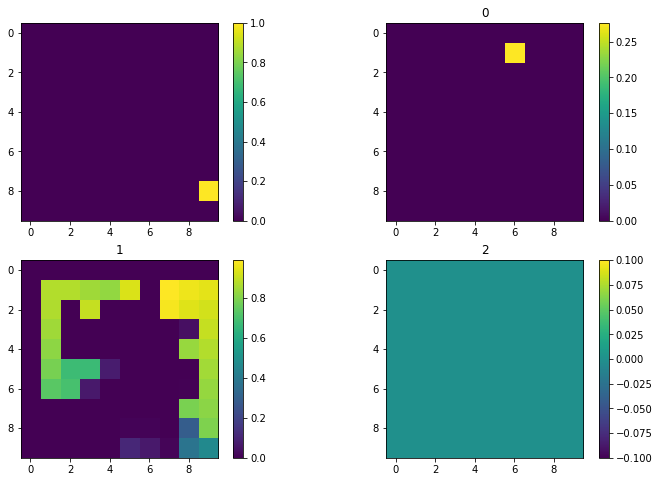

In [55]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(structural_gvf.sr[1,1]))
plt.colorbar()
for i in range(3):
    plt.subplot(2, 2, i + 2)
    plt.imshow(np.squeeze(structural_gvf.gvfs[1,1,0])[:, :, i])
    plt.title(i)
    plt.colorbar()

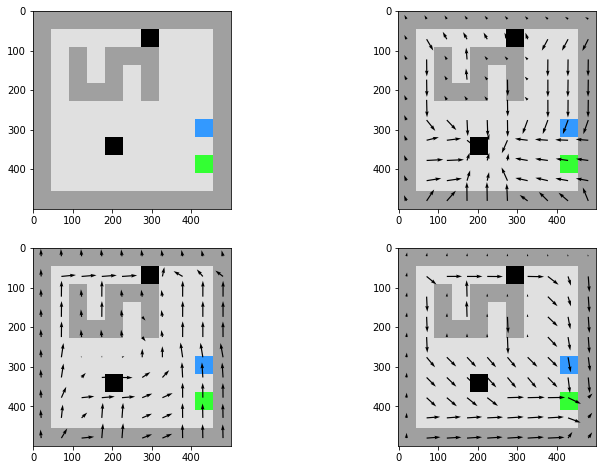

In [50]:
env.reset()
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
img = env.render('rgb_array')    
plt.imshow(img)
policy_all_states_k1 = logits_net.get_policy_all_states(env, gvf_net_k1,0, device)
policy_all_states_k2 = logits_net.get_policy_all_states(env, gvf_net_k2,1, device)
policy_all_states_xf = logits_net.get_policy_all_states(env, gvf_net_xf,2, device)

# figure of policy network
img = env.render('rgb_array')  
plt.subplot(2, 2, 2)
plt.imshow(img)
plt.quiver(x_grid, 
           y_grid, 
           policy_all_states_k1[:,:,3] - policy_all_states_k1[:,:,2],
           policy_all_states_k1[:,:,0] - policy_all_states_k1[:,:,1])

plt.subplot(2, 2, 3)
plt.imshow(img)
plt.quiver(x_grid, 
           y_grid, 
           policy_all_states_k2[:,:,3] - policy_all_states_k2[:,:,2],
           policy_all_states_k2[:,:,0] - policy_all_states_k2[:,:,1])

plt.subplot(2, 2, 4)
plt.imshow(img)
plt.quiver(x_grid, 
           y_grid, 
           policy_all_states_xf[:,:,3] - policy_all_states_xf[:,:,2],
           policy_all_states_xf[:,:,0] - policy_all_states_xf[:,:,1])

In [ ]:
pos   = np.squeeze(env.maze.objects.agent.positions).copy()
state = np.array(np.concatenate((np.array(sub_state)[:-1], pos)), dtype=np.int)

# behavior policy
obs = format_input(pos, nav_goal, size, beha_gvf)

# get act and prob
act, _ = logits_net.get_action(torch.as_tensor(obs, dtype=torch.float32).to(device))
pi_behav = np.array(logits_net.get_policy(torch.as_tensor(obs, 
                                                          dtype=torch.float32).
                                          to(device), None)[0].probs.detach()[act])

# get target
pi_targets = np.array([
                       logits_net.get_policy(torch.as_tensor(format_input(pos, g, size, b), 
                                                             dtype=torch.float32).to(device)
                                             ,None)[0].probs.detach()[act] 
                       for (g, b) in zip(nav_goals, nav_gvfs)])

# move
_, sub_state, done, _ = env.step(act)

# next position
pos_next = np.squeeze(env.maze.objects.agent.positions).copy()

# utility
utility = (sub_state[-1] == 1) * 1.

# next state
state_next = np.array(np.concatenate((np.array(sub_state)[:-1], pos_next)), dtype=np.int)

# update structural gvfs
structural_gvf.update(state, utility, act, state_next, L, pi_behav=pi_behav, pi_targets=pi_targets)

In [ ]:
np.where(structural_gvf.gvfs[0,1,1][:, :, 0, 0] != 0)
print(state)
print(state_next)

In [ ]:
plt.imshow(structural_gvf.gvfs[0,0,1][:, :, 0, 2])

In [ ]:
#    structural_gvf.update(state, utility, which_navigation_policy, state_next, L, 
#                          pi_behav=pi_behav, pi_targets=pi_targets)
act = which_navigation_policy
self = structural_gvf
if ((pi_behav != 0.25) and pi_targets is None) or \
        (pi_behav is None and pi_targets is None):
    raise ValueError('pi_behav should be 0.25 and pi_targets None (case of exploratory phase for navigational'
                     ' GVFs learning) or both should be specified (case of structural GVFs learning)')
# importance sampling weight for off-policy TD learning
if pi_targets is None:
    IS_weights = np.ones(self.num_actions)
else:
    IS_weights = pi_targets / pi_behav
    if len(IS_weights) != self.num_actions:
        raise ValueError('This is a mismatch in the dimension of pi_targets and self.num_actions')
if np.any(np.isnan(IS_weights)):
    raise ValueError('is_weight is NaN')
if np.any(IS_weights != 1) and self.nb_subgoals_in_state == 0:
    raise ValueError('off-policy TD is not developed yet for navigational GVFs')
if np.all(IS_weights == 1) and self.nb_subgoals_in_state > 0:
    raise ValueError('pi_behav and pi_targets must be defined for structural GVFs')
for g in range(self.num_gammas):
    self.Q_gamma[tuple(state) + (g, act)] = self.Q_gamma[tuple(state) + (g, act)] + \
                                            self.lr['Q'] * (
                                                    utility + (1 - utility) * self.gammas[g] *
                                                    np.max(
                                                        self.Q_gamma[tuple(state_next) + (g,)]
                                                    )
                                                    - self.Q_gamma[tuple(state) + (g, act)]
                                            )
    if self.depth > 0:
        # successor representation under the default policy
        has_sr = 1 if (self.nb_subgoals_in_state == 0) else 0

        self.sr[tuple(state) + (g,)] = self.sr[tuple(state) + (g,)] \
                                       + self.lr['sr'] * (utility + (1 - utility) * 0.25 / pi_behav * has_sr *
                                                          self.gammas[g] * self.sr[tuple(state_next) + (g,)]
                                                          - self.sr[tuple(state) + (g,)]
                                                          )
        for i_depth in range(self.depth):
            if self.nb_subgoals_in_state == 0:
                assert (self.num_actions == 4), 'navigational gvfs not implemented in the case nb_actions != 4'
                iterate_obj = range(self.num_actions), state + np.array([[1, 0], [-1, 0], [0, -1], [0, 1]]), \
                              np.arange(2, 4)[None] - (np.arange(4)[:, None] > 1) * 2, IS_weights
            else:
                iterate_obj = np.arange(self.num_actions), np.tile(state_next[None], (self.num_actions, 1)), \
                              np.vstack([np.delete(np.arange(self.num_actions), k)[None]
                                         for k in range(self.num_actions)]), IS_weights
                # take out IS
                iterate_obj = [k[iterate_obj[-1] == 1] for k in iterate_obj]

            # iterate_obj = gvf_id, next_pos, orth_gfvs, is_weight
            for i_act, p, i_c, is_w in zip(*iterate_obj):
                if i_depth==2 and i_act==0:assert(False)
                if np.any(np.all(L == p[-2:], axis=1)):
                    cumulant = (self.sr[tuple(p) + (g,)] > self.thresholds['sr']
                                > self.sr[tuple(state) + (g,)]
                                ) * 1 if (i_depth == 0) else \
                        np.any(self.gvfs[(i_depth - 1,) + tuple(p) + (g, i_c)] > self.thresholds['gvfs']) * \
                        ((not has_sr) or np.all(self.gvfs[(range(i_depth),) + tuple(state) + (g,)] < self.thresholds['gvfs'])) * \
                        (self.sr[tuple(state) + (g,)] < self.thresholds['sr']) * 1

                    self.gvfs[(i_depth,) + tuple(state) + (g, i_act)] = self.gvfs[
                                                                            (i_depth,) + tuple(state) + (
                                                                            g, i_act)] \
                                                                        + self.lr['gvfs'] * \
                                                                        (cumulant + (1 - cumulant) * is_w *
                                                                         self.gammas[g] * self.gvfs[
                                                                             (i_depth,) + tuple(p) + (g, i_act)]
                                                                         - self.gvfs[
                                                                             (i_depth,) + tuple(state) + (
                                                                             g, i_act)]
                                                                         )

In [ ]:
                    cumulant = (self.sr[tuple(p) + (g,)] > self.thresholds['sr']
                                > self.sr[tuple(state) + (g,)]
                                ) * 1 if (i_depth == 0) else \
                        np.any(self.gvfs[(i_depth - 1,) + tuple(p) + (g, i_c)] > self.thresholds['gvfs']) * \
                        ((not has_sr) or np.all(self.gvfs[(range(i_depth),) + tuple(state) + (g,)] < self.thresholds['gvfs'])) * \
                        (self.sr[tuple(state) + (g,)] < self.thresholds['sr']) * 1

In [ ]:
cumulant

In [ ]:
 self.gvfs[(i_depth,) + tuple(state) + (g, i_act)]

In [ ]:
i_depth

In [ ]:
np.all(self.gvfs[(range(i_depth),) + tuple(state) + (g,)])

In [ ]:
self.gvfs[(range(i_depth),) + tuple(state) + (g,)]

In [ ]:
self.gvfs[(range(i_depth),) + tuple(state) + (g,)] < self.thresholds['gvfs']

In [ ]:
self.gvfs[
                                                                            (i_depth,) + tuple(state) + (
                                                                            g, i_act)] \
                                                                        + self.lr['gvfs'] * \
                                                                        (cumulant + (1 - cumulant) * is_w *
                                                                         self.gammas[g] * self.gvfs[
                                                                             (i_depth,) + tuple(p) + (g, i_act)]
                                                                         - self.gvfs[
                                                                             (i_depth,) + tuple(state) + (
                                                                             g, i_act)]
                                                                         )

In [ ]:
self.sr#[tuple(p) + (g,)]

In [ ]:
size = gvf_net_xf.size
num_actions = gvf_net_xf.num_actions
L = env.maze.objects.free.positions

# reset episode
_, done = env.reset(), False


while True:

    # if exploration phase is True move randomly
    if np.any([(i - k) % change == 0 for k in range(nb_episodes_random_policy)]):
        act = np.random.randint(num_actio)
    else: 
        act, _ = logits_net.get_action(torch.as_tensor(obs, dtype=torch.float32).to(device))
        proba_beh = logits_net.get_action(torch.as_tensor(obs, dtype=torch.float32).to(device))
        
    # move
    _, _, done, _ = env.step(act)

    # next position
    pos_next = np.squeeze(env.maze.objects.agent.positions).copy()

    # utility at next position
    utility_xf = np.all(pos_next == xf_pos) * 1.
    utility_k1 = np.all(pos_next == k1_pos) * 1.
    utility_k2 = np.all(pos_next == k2_pos) * 1.

    # update gvfs in exploratory phase
    if np.any([(i - k) % change == 0 for k in range(nb_episodes_random_policy)]):
        gvf_net_k1.update(pos, utility_k1, act, pos_next, L)
        gvf_net_k2.update(pos, utility_k2, act, pos_next, L)
        gvf_net_xf.update(pos, utility_xf, act, pos_next, L)

    # terminate if one of the subgoals was found (or at 200 steps):
    if which_subgoal==0 and utility_k1==1:
        rew = 50
        done = True
    elif which_subgoal==1 and utility_k2==1:
        rew = 50
        done = True
    elif which_subgoal==2 and utility_xf==1:
        rew = 50
        done = True            
    else:
        rew = -0.2

    if done == True:
        # reset env
        _, done, ep_rews = env.reset(), False, []

In [ ]:
def reward_to_go(rewards):
    n = len(rewards)
    rtgs = np.zeros_like(rewards)
    for i in reversed(range(n)):
        rtgs[i] = rewards[i] + (rtgs[i + 1] if i + 1 < n else 0)
    return rtgs


def format_input(pos, r_pos, size, gvf_net) -> np.array:
    return np.array([(pos[0] - size / 2) / 25, (pos[1] - size / 2) / 25,
           (r_pos[0] - size / 2) / 25, (r_pos[1] - size / 2) / 25] + \
           gvf_net.gvfs[:, pos[0], pos[1], :, :].flatten().tolist() + \
           gvf_net.Q_gamma[pos[0], pos[1], :, :].flatten().tolist())